In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from entsoe import EntsoeRawClient
from entsoe import EntsoePandasClient

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import mean_absolute_error,mean_squared_error


# from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,LSTM,Input,Flatten
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates
from numpy import array

# Plots
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-notebook')


# Time-series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Modelling and Forecasting
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

# Keras
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN, Dropout, GRU, Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Embedding
from keras.optimizers import SGD
from keras.layers import Input
from keras.layers import concatenate

import pickle 
#pd.set_option('display.max_rows', None)

## Read countries

In [2]:
def read_countries(df):

    df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
    df = df.set_index('Unnamed: 0')
    df.index.freq ='60min'
    df = df[['True value','Provider 1','Provider 2','Provider 3','hour','dayofweek','month','is_weekend','quarter']]

    return df

In [3]:
romania = read_countries(pd.read_csv('romania.csv'))

## Adding cyclical features

In [4]:
def cyclical_features(df):

    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24.0)
    
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek']/7.0)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek']/7.0)

    df.drop(['hour','dayofweek','month','is_weekend','quarter'],axis=1,inplace=True)

    return df

cyclical_romania = cyclical_features(romania)

### Romania

In [5]:
cyclical_romania

,True value,Provider 1,Provider 2,Provider 3,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos
Unnamed: 0,,,,,,,,
2024-01-01 00:00:00+00:00,0.01,0.01,14.45,5.158431,0.000000,1.000000,0.781831,0.62349
2024-01-01 01:00:00+00:00,0.04,0.00,11.90,2.072549,0.258819,0.965926,0.781831,0.62349
2024-01-01 02:00:00+00:00,0.01,0.00,10.56,1.650392,0.500000,0.866025,0.781831,0.62349
2024-01-01 03:00:00+00:00,0.01,0.00,9.72,2.854314,0.707107,0.707107,0.781831,0.62349
2024-01-01 04:00:00+00:00,0.01,0.00,10.57,5.399020,0.866025,0.500000,0.781831,0.62349
...,...,...,...,...,...,...,...,...
2024-08-31 19:00:00+00:00,160.02,126.25,168.92,158.948627,-0.965926,0.258819,-0.781831,0.62349
2024-08-31 20:00:00+00:00,134.91,110.10,137.68,120.522941,-0.866025,0.500000,-0.781831,0.62349
2024-08-31 21:00:00+00:00,116.29,95.30,124.74,95.616078,-0.707107,0.707107,-0.781831,0.62349


## Splitting Data

In [6]:
X_train = cyclical_romania.loc[:'2024-07-31 23:00:00']

X_val = cyclical_romania.loc['2024-08-01 00:00:00':'2024-08-15 23:00:00']

X_test = cyclical_romania.loc['2024-08-16 00:00:00':]

In [7]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == len(cyclical_romania)

True

## Scaling

In [8]:
scaler = MinMaxScaler()

data_train_scaled = scaler.fit_transform(X_train.values)

data_val_scaled = scaler.transform(X_val.values)

data_test_scaled = scaler.transform(X_test.values)

## Creating Functions

In [9]:
def daily_evaluation(y_test, y_pred, data_test,title):

  hours = np.arange(0, 24)

  plt.plot(hours,y_test, label = 'True values',marker='o')
  plt.plot(y_pred, label = 'Predicted values',marker='x',linestyle='--')

  #plt.xticks( np.arange(0, len(data_test), 383),  data_test.index [np.arange(0, len(data_test), 383)], rotation=45)


  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Price of MWh')
  plt.legend()
  plt.show()

  mape = mean_absolute_percentage_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)


  mape = np.round(mape,3)
  mae = np.round(mae,3)
  mse = np.round(mse,3)




  print('MAPE: %f   --  MAE: %f  --  MSE: %f' % (mape, mae, mse))

  return

In [10]:
def weekly_evaluation(y_test, y_pred, data_test,title,dates):


    plt.plot(dates, y_test, color='red', label='Actual')
    plt.plot(dates, y_pred, color='blue', label='Predicted')


    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))


    plt.xticks(rotation=0)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('MWatt')
    plt.legend()


    plt.show()

    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    mape = np.round(mape,3)
    mae = np.round(mae,3)
    mse = np.round(mse,3)




    print('MAPE: %f   --  MAE: %f  --  MSE: %f' % (mape, mae, mse))

    return

In [11]:
def evaluation(y_test, y_pred, data_test):

  plt.plot(y_test, color = 'red', label = 'Actual')
  plt.plot(y_pred, color = 'blue', label = 'Predicted')

  plt.xticks( np.arange(0, len(data_test), 100),  data_test.index [np.arange(0, len(data_test), 100)], rotation=45)


  plt.title('Forecasting electricity demand')
  plt.xlabel('Time')
  plt.ylabel('MWatt')
  plt.legend()
  plt.show()

  mape = mean_absolute_percentage_error(y_test, y_pred)
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)


  mape = np.round(mape,3)
  mae = np.round(mae,3)
  mse = np.round(mse,3)


  print('MAPE: %f   --  MAE: %f  --  MSE: %f' % (mape, mae, mse))

  return

## Seq2seq 

### Seq2seq Input 48 - Output 24 - MAE = 30.87

In [12]:
# Assuming X_train, X_val, X_test are already loaded as numpy arrays
# Column indices
target_index = 0
features_indices = [1, 2, 3, 4, 5, 6, 7]

# Extract features and target
def extract_features_and_target(X):
    X_features = X.iloc[:, features_indices]
    y = X.iloc[:, target_index]
    return X_features, y

X_train_features, y_train = extract_features_and_target(X_train)
X_val_features, y_val = extract_features_and_target(X_val)
X_test_features, y_test = extract_features_and_target(X_test)

# Sequence parameters
encoder_seq_length = 48  # Input sequence length
decoder_seq_length = 24  # Output sequence length
num_features = X_train_features.shape[1]

# Function to create encoder and decoder sequences
def create_sequences(features, target, encoder_seq_length, decoder_seq_length):
    X_enc = []
    X_dec = []
    y_seq = []
    for i in range(len(features) - encoder_seq_length - decoder_seq_length + 1):
        X_enc.append(features[i:i+encoder_seq_length])
        # For decoder input, we can use the previous target values (teacher forcing)
        # Here, we use zeros or shift the target sequence (depends on implementation)
        X_dec.append(target[i+encoder_seq_length-1:i+encoder_seq_length+decoder_seq_length-1])
        y_seq.append(target[i+encoder_seq_length:i+encoder_seq_length+decoder_seq_length])
    return np.array(X_enc), np.array(X_dec), np.array(y_seq)

# Create sequences
X_train_enc, X_train_dec, y_train_seq = create_sequences(X_train_features, y_train, encoder_seq_length, decoder_seq_length)
X_val_enc, X_val_dec, y_val_seq = create_sequences(X_val_features, y_val, encoder_seq_length, decoder_seq_length)
X_test_enc, X_test_dec, y_test_seq = create_sequences(X_test_features, y_test, encoder_seq_length, decoder_seq_length)

# Reshape decoder input and target sequences
X_train_dec = X_train_dec.reshape((X_train_dec.shape[0], X_train_dec.shape[1], 1))
X_val_dec = X_val_dec.reshape((X_val_dec.shape[0], X_val_dec.shape[1], 1))
X_test_dec = X_test_dec.reshape((X_test_dec.shape[0], X_test_dec.shape[1], 1))

y_train_seq = y_train_seq.reshape((y_train_seq.shape[0], y_train_seq.shape[1], 1))
y_val_seq = y_val_seq.reshape((y_val_seq.shape[0], y_val_seq.shape[1], 1))
y_test_seq = y_test_seq.reshape((y_test_seq.shape[0], y_test_seq.shape[1], 1))


# Encoder
encoder_inputs = Input(shape=(encoder_seq_length, num_features), name='encoder_inputs')
encoder_lstm1 = LSTM(128, return_sequences=True, name='encoder_lstm1')(encoder_inputs)
encoder_dropout1 = Dropout(0.3, name='encoder_dropout1')(encoder_lstm1)
encoder_lstm2 = LSTM(64, return_state=True, name='encoder_lstm2')
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_dropout1)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(decoder_seq_length, 1), name='decoder_inputs')
decoder_lstm1 = LSTM(64, return_sequences=True, name='decoder_lstm1')
decoder_outputs = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_dropout1 = Dropout(0.3, name='decoder_dropout1')(decoder_outputs)
decoder_lstm2 = LSTM(32, return_sequences=True, name='decoder_lstm2')
decoder_outputs = decoder_lstm2(decoder_dropout1)
decoder_dense = Dense(1, name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn encoder_inputs and decoder_inputs into decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_seq2seq_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Train the model
history = model.fit(
    [X_train_enc, X_train_dec], y_train_seq,
    epochs=100,
    batch_size=16,
    validation_data=([X_val_enc, X_val_dec], y_val_seq),
    callbacks=callbacks
)

# Load the best model
model.load_weights('best_seq2seq_model.keras')

# Predict on the test set
y_pred_seq = model.predict([X_test_enc, X_test_dec])

# Flatten predictions and true values
y_pred = y_pred_seq.flatten()
y_true = y_test_seq.flatten()

# Calculate MAE, MAPE, and MSE
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Squared Error (MSE): {mse}")

Epoch 1/100
315/316 [============================>.] - ETA: 0s - loss: 10743.4189
Epoch 1: val_loss improved from inf to 13600.68555, saving model to best_seq2seq_model.keras
316/316 [==============================] - 9s 21ms/step - loss: 10742.3936 - val_loss: 13600.6855 - lr: 0.0010
Epoch 2/100
316/316 [==============================] - ETA: 0s - loss: 9136.3027
Epoch 2: val_loss improved from 13600.68555 to 11802.87305, saving model to best_seq2seq_model.keras
316/316 [==============================] - 6s 20ms/step - loss: 9136.3027 - val_loss: 11802.8730 - lr: 0.0010
Epoch 3/100
313/316 [============================>.] - ETA: 0s - loss: 7985.4878
Epoch 3: val_loss improved from 11802.87305 to 10298.17188, saving model to best_seq2seq_model.keras
316/316 [==============================] - 6s 19ms/step - loss: 7965.0869 - val_loss: 10298.1719 - lr: 0.0010
Epoch 4/100
313/316 [============================>.] - ETA: 0s - loss: 6994.0454
Epoch 4: val_loss improved from 10298.17188 to 90

### Seq2seq Input 24 - Output 24 - MAE = 29.20

In [13]:
target_index = 0
features_indices = [1, 2, 3, 4, 5, 6, 7]

# Extract features and target
def extract_features_and_target(X):
    X_features = X.iloc[:, features_indices]
    y = X.iloc[:, target_index]
    return X_features, y

X_train_features, y_train = extract_features_and_target(X_train)
X_val_features, y_val = extract_features_and_target(X_val)
X_test_features, y_test = extract_features_and_target(X_test)

# Sequence parameters
encoder_seq_length = 24  # Input sequence length
decoder_seq_length = 24  # Output sequence length
num_features = X_train_features.shape[1]

# Function to create encoder and decoder sequences
def create_sequences(features, target, encoder_seq_length, decoder_seq_length):
    X_enc = []
    X_dec = []
    y_seq = []
    for i in range(len(features) - encoder_seq_length - decoder_seq_length + 1):
        X_enc.append(features[i:i+encoder_seq_length])
        # For decoder input, we can use the previous target values (teacher forcing)
        # Here, we use zeros or shift the target sequence (depends on implementation)
        X_dec.append(target[i+encoder_seq_length-1:i+encoder_seq_length+decoder_seq_length-1])
        y_seq.append(target[i+encoder_seq_length:i+encoder_seq_length+decoder_seq_length])
    return np.array(X_enc), np.array(X_dec), np.array(y_seq)

# Create sequences
X_train_enc, X_train_dec, y_train_seq = create_sequences(X_train_features, y_train, encoder_seq_length, decoder_seq_length)
X_val_enc, X_val_dec, y_val_seq = create_sequences(X_val_features, y_val, encoder_seq_length, decoder_seq_length)
X_test_enc, X_test_dec, y_test_seq = create_sequences(X_test_features, y_test, encoder_seq_length, decoder_seq_length)

# Reshape decoder input and target sequences
X_train_dec = X_train_dec.reshape((X_train_dec.shape[0], X_train_dec.shape[1], 1))
X_val_dec = X_val_dec.reshape((X_val_dec.shape[0], X_val_dec.shape[1], 1))
X_test_dec = X_test_dec.reshape((X_test_dec.shape[0], X_test_dec.shape[1], 1))

y_train_seq = y_train_seq.reshape((y_train_seq.shape[0], y_train_seq.shape[1], 1))
y_val_seq = y_val_seq.reshape((y_val_seq.shape[0], y_val_seq.shape[1], 1))
y_test_seq = y_test_seq.reshape((y_test_seq.shape[0], y_test_seq.shape[1], 1))

# Encoder
encoder_inputs = Input(shape=(encoder_seq_length, num_features), name='encoder_inputs')
encoder_lstm1 = LSTM(128, return_sequences=True, name='encoder_lstm1')(encoder_inputs)
encoder_dropout1 = Dropout(0.3, name='encoder_dropout1')(encoder_lstm1)
encoder_lstm2 = LSTM(64, return_state=True, name='encoder_lstm2')
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_dropout1)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(decoder_seq_length, 1), name='decoder_inputs')
decoder_lstm1 = LSTM(64, return_sequences=True, name='decoder_lstm1')
decoder_outputs = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
decoder_dropout1 = Dropout(0.3, name='decoder_dropout1')(decoder_outputs)
decoder_lstm2 = LSTM(32, return_sequences=True, name='decoder_lstm2')
decoder_outputs = decoder_lstm2(decoder_dropout1)
decoder_dense = Dense(1, name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn encoder_inputs and decoder_inputs into decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_seq2seq_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

# Train the model
history = model.fit(
    [X_train_enc, X_train_dec], y_train_seq,
    epochs=100,
    batch_size=16,
    validation_data=([X_val_enc, X_val_dec], y_val_seq),
    callbacks=callbacks
)

# Load the best model
model.load_weights('best_seq2seq_model.keras')

# Predict on the test set
y_pred_seq = model.predict([X_test_enc, X_test_dec])

# Flatten predictions and true values
y_pred = y_pred_seq.flatten()
y_true = y_test_seq.flatten()

# Calculate MAE, MAPE, and MSE
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# Print the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Squared Error (MSE): {mse}")

Epoch 1/100
316/317 [============================>.] - ETA: 0s - loss: 10608.2100
Epoch 1: val_loss improved from inf to 13205.30664, saving model to best_seq2seq_model.keras
317/317 [==============================] - 7s 14ms/step - loss: 10602.8955 - val_loss: 13205.3066 - lr: 0.0010
Epoch 2/100
315/317 [============================>.] - ETA: 0s - loss: 9075.5234
Epoch 2: val_loss improved from 13205.30664 to 11477.97168, saving model to best_seq2seq_model.keras
317/317 [==============================] - 4s 13ms/step - loss: 9055.6191 - val_loss: 11477.9717 - lr: 0.0010
Epoch 3/100
315/317 [============================>.] - ETA: 0s - loss: 7923.6597
Epoch 3: val_loss improved from 11477.97168 to 10029.28223, saving model to best_seq2seq_model.keras
317/317 [==============================] - 4s 13ms/step - loss: 7920.9541 - val_loss: 10029.2822 - lr: 0.0010
Epoch 4/100
313/317 [============================>.] - ETA: 0s - loss: 7007.3018
Epoch 4: val_loss improved from 10029.28223 to 88

### Seq2Seq Evaluation

### Weekly evaluation

In [14]:
y_test_final = y_test_seq[0::24][-14:-7].flatten()
y_pred_final = y_pred_seq[0::24][-14:-7].flatten()

In [15]:
y_test_final.shape

(168,)

In [16]:
mean_absolute_error(y_test_final,y_pred_final)

25.411397845972154

In [17]:
dates = pd.date_range(start="2024-08-18 00:00:00", end="2024-08-24 23:00:00", freq='h')

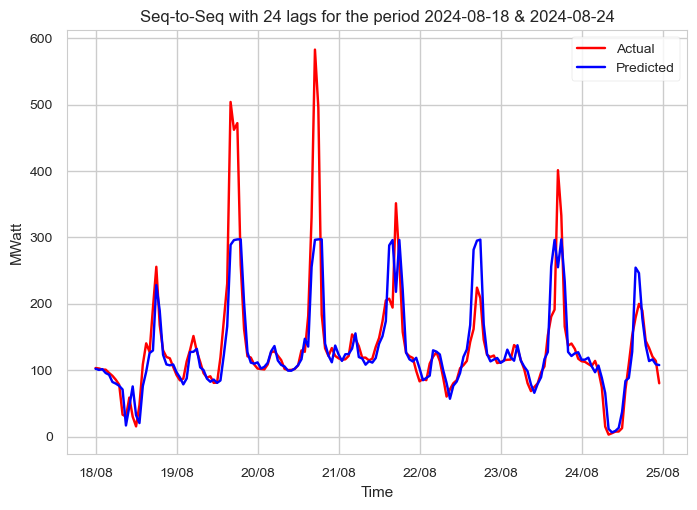

MAPE: 0.210000   --  MAE: 25.411000  --  MSE: 2438.465000


In [18]:
weekly_evaluation(y_test_final,y_pred_final,X_test,f'Seq-to-Seq with 24 lags for the period {dates[0].date()} & {dates[-1].date()}',dates)

<Figure size 1500x600 with 0 Axes>

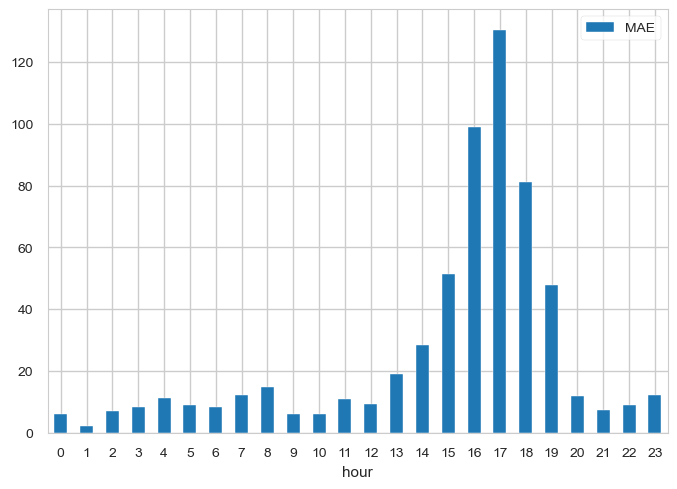

In [19]:
dates = pd.date_range(start='2024-08-18 00:00:00', end='2024-08-24 23:00:00', freq='h')

mae_lstm = abs(y_test_final - y_pred_final)

mae_df_lstm = pd.DataFrame(mae_lstm,index=dates,columns=['MAE'])
mae_df_lstm['hour'] = mae_df_lstm.index.hour

plt.figure(figsize=(15,6))
mae_df_lstm.groupby('hour').mean().plot(kind='bar',rot=0)

plt.show()

### Daily evaluation

In [20]:
y_test_final_lastday = y_test_seq[0::24][-1].flatten()
y_pred_final_lastday = y_pred_seq[0::24][-1].flatten()

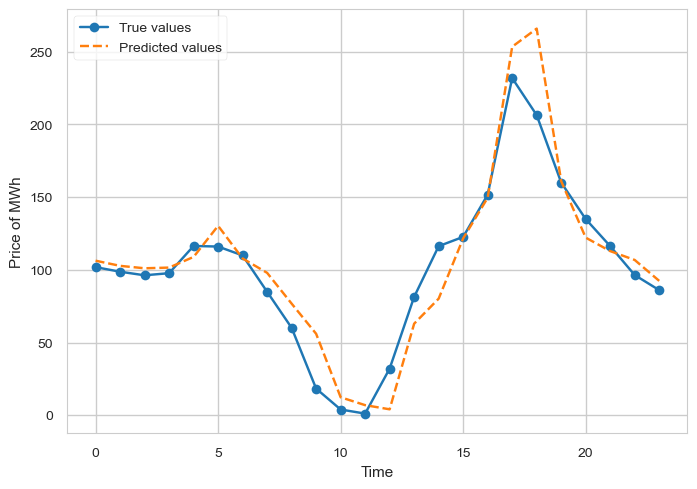

MAPE: 0.511000   --  MAE: 13.466000  --  MSE: 377.828000


In [21]:
daily_evaluation(y_test_final_lastday,y_pred_final_lastday,X_test,"")